
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Preprocessing:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

In here, we add a separator token "sep". It will serve to indicate when a utteration is over, and another one starts. We also add a padding token at the end to ensure that all inputs have same dimention.


In [1]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo

# eventually include tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import os
import matplotlib.pyplot as plt
import gensim
from nltk.tokenize import TweetTokenizer

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from collections import Counter

import pandas as pd
import numpy as np

In [3]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

--2025-01-20 08:34:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   108MB/s    in 5.3s    

2025-01-20 08:34:51 (122 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [4]:
## taken from template
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec",binary = False)

In [5]:
## We create the embeddings and find the vocab
import copy
unk_token, pad_token, sep_token = '<unk>', '<pad>','<sep>'
embedding_vectors = torch.from_numpy(encoder_model.vectors)
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [pad_token, unk_token,sep_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.zeros(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((-torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))

In [6]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

max_size = 50
## By using the template that was shared, we can process the inputs in a very similar way
tok = TweetTokenizer()
def tokenize_text_extend_emotions(text,emotion,stoi): ## utteration : string -> list of tokenized words : [int]
  text = tok.tokenize(text)
  text = [stoi[word] if word in stoi else stoi['<unk>'] for word in text]
  return text, [emotion]*len(text)

def concat_utt(dialog, emotions, stoi, max_size=max_size + 1): ## list of utterations : [string] -> list of list of tokenized words : [int]
  tokenized_and_extended = [tokenize_text_extend_emotions(t,e,stoi) for t,e in zip(dialog,emotions)]
  dialog = [i[0] for i in tokenized_and_extended]
  emotions = [i[1] for i in tokenized_and_extended]
  dialog_flat = []
  emotions_extended = []
  for i in range(len(dialog) - 1):
    dialog[i].append(stoi["<sep>"])
    emotions[i].append(emotions[i][0])
  for i in range(len(dialog)):
    dialog_flat.extend(dialog[i])
    emotions_extended.extend(emotions[i])
  if len(dialog_flat) > max_size: ## Must cut
    dialog_flat = dialog_flat[:max_size]
    emotions_extended = emotions_extended[:max_size]
  else: ## Must add padding
    dialog_flat += [stoi["<pad>"]] * (max_size - len(dialog_flat))
    emotions_extended += [0] * (max_size - len(emotions_extended))
  return dialog_flat,emotions_extended

def adjust_emotion_labels(Y): ## Necessary, because we will use 0 as padding for both the text and emotions.
  for i in range(len(Y)):
    for j in range(len(Y[i])):
      Y[i][j] = Y[i][j] + 1
  return Y

def preprocess_data(X,Y): ## list of lists of utterations : [[string]] -> list of lists of tokenized words : [[int]]
  X_processed = []
  Y_processed = []
  Y = adjust_emotion_labels(Y) ## sums 1 to all emotions (<pad_token> = 0)
  for i in tqdm(range(len(X))):
    X_processed.append(concat_utt(X[i],Y[i],stoi)[0])
    Y_processed.append(concat_utt(X[i],Y[i],stoi)[1])
  return X_processed, Y_processed

def get_target(X,Y): ## generates the target values and input values
  text_input = [i[:-1] for i in X]
  text_target = [i[1:] for i in X]
  emotion_input = [i[:-1] for i in Y]
  emotion_target = [i[1:] for i in Y]
  return text_input, text_target, emotion_input, emotion_target


## Check the following example:
dialog_example = ["hello, I am a I robot!","I am greek"]
emotions_example = [1,2] ## random emotions...

flatten_dialog, flatten_emotions = concat_utt(dialog_example,emotions_example,stoi)
print(f"{dialog_example} becomes {flatten_dialog}")
print(f"{emotions_example} becomes {flatten_emotions}")


['hello, I am a I robot!', 'I am greek'] becomes [13172, 3, 31, 784, 10, 31, 6872, 80, 2, 31, 784, 22505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 2] becomes [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## DataLoader not implemented yet:

In [7]:
## Modify this after changing the preprocessing.
class DailyDialogDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for Daily Dialog dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item



Here we will extract the data:

In [8]:
data = load_dataset('daily_dialog')

X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
X_train, Y_train = preprocess_data(X_train,Y_train)
X_train,X_train_target, Y_train, Y_train_target = get_target(X_train,Y_train)

X_test, Y_test = preprocess_data(X_test,Y_test)
X_test,X_test_target, Y_test, Y_test_target = get_target(X_test,Y_test)

X_val, Y_val = preprocess_data(X_val,Y_val)
X_val,X_val_target, Y_val, Y_val_target = get_target(X_val,Y_val)


## Just checking if nothing wrong happened
for d, e in zip(X_train,Y_train):
  assert(len(d) == len(e))
for d, e in zip(X_test,Y_test):
  assert(len(d) == len(e))
for d, e in zip(X_val,Y_val):
  assert(len(d) == len(e))

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
batch_size = 5

train_data = DailyDialogDataset(X_train,Y_train,X_train_target,Y_train_target)
test_data = DailyDialogDataset(X_test_target,Y_test_target,X_test_target,Y_test_target)
val_data = DailyDialogDataset(X_val_target,Y_val_target,X_val_target,Y_val_target)

train_loader = DataLoader(train_data, batch_size=batch_size,shuffle = True,)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True)

## Example:
train_data[2] ## note that padding = 0

{'texts': array([2221,   33,  339,   20,    4, 1685,   18,   40,    2,  423,    3,
          31, 6053,    8, 1412,  431,    5,    2,  368,   16,    4, 1549,
          40,    2,   23, 1685,   46,  216,  128,    1,    5,    2,    1,
         582,    3,   50,   90,   33,   39,    8, 1691,   10,  444,  760,
           5,    0,    0,    0,    0,    0]),
 'emotions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0]),
 'target_texts': array([  33,  339,   20,    4, 1685,   18,   40,    2,  423,    3,   31,
        6053,    8, 1412,  431,    5,    2,  368,   16,    4, 1549,   40,
           2,   23, 1685,   46,  216,  128,    1,    5,    2,    1,  582,
           3,   50,   90,   33,   39,    8, 1691,   10,  444,  760,    5,
           0,    0,    0,    0,    0,    0]),
 'target_emotions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1,

# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (Not implemented yet)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [11]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, emo_dim, n_emotion, n_vocab):
    super(SimpleModel,self).__init__()
    ## word_dim = 300

    self.embedding_layer_text = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
    self.embedding_layer_emotion = nn.Embedding(n_emotion, emo_dim)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(300,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)

    # self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(emo_dim,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    # self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final1 = nn.Linear(380, 180)
    self.Linear_utt_final2 = nn.Linear(180, 90)
    self.Linear_utt_final3 = nn.Linear(90, 15)
    self.Linear_utt_final = nn.Linear(15, n_vocab)
    self.Linear_emo_final = nn.Linear(380, n_emotion)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text, emotion):
    ## first input channel:
    #mask_text = (emb_text != 0).unsqueeze(-1).float()       ## not considered by gradient!
    #mask_emotion = (emb_emotion != 0).unsqueeze(-1).float() ## not considered by gradient!

    #x = (emb_text * mask_text).int()
    #y = (emb_emotion * mask_emotion).int()
    with torch.no_grad():
      text = self.embedding_layer_text(text)
    text = self.Linear_utt1(text)
    text = self.Linear_utt2(text)
    text = self.Linear_utt3(text)

    emotion = self.embedding_layer_emotion(emotion)
    emotion = self.Linear_emo1(emotion)
    emotion = self.Linear_emo2(emotion)
    emotion = self.Linear_emo3(emotion)

    z = torch.cat((text,emotion),-1)
    z = self.Linear_fus(z)

    text = torch.cat((z,text),-1)
    text = self.Linear_utt_final1(text)
    text = self.Linear_utt_final2(text)
    text = self.Linear_utt_final3(text)
    text = self.Linear_utt_final(text)
    text = self.softmax(text)

    emotion = torch.cat((z,emotion),-1)
    emotion = self.Linear_emo_final(emotion)
    emotion = self.softmax(emotion)

    return text, emotion



In [12]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## normal train function
def train(model, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss = 0
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):

      batch = {'texts': batch['texts'].to(device),
               'emotions': batch['emotions'].to(device),
               'target_texts': batch['target_texts'].view(-1).to(device), ## reshape is necessary to compare predictions
               'target_emotions': batch['target_emotions'].view(-1).to(device)}
      optimizer.zero_grad()
      pt,pe = model.forward(batch['texts'],batch['emotions'])

      ## reshaping so we can compute loss
      pt = pt.view(-1,len(stoi))
      pe = pe.view(-1,8)

      ## loss(pe) + loss(pt) [slow + RAM issue - cannot do it on cpu] vs. loss(pe) [extremely faster]
      loss = loss_fn(pe,batch['target_emotions']) + loss_fn(pt, batch['target_texts'])
      loss.backward()
      optimizer.step()

      ## it will help us with the plots:
      losses.append(loss.item())
    loss_to_append = sum(losses)/len(losses)
    loss_to_plot.append(loss_to_append)
    print(f"loss: ",loss_to_append)

  return loss_to_plot


In [13]:
from torchinfo import summary

## Setting some hyper parameters:
device = activate_gpu()
emotion_dim = 30
n_emotions = 8
n_words = len(stoi)

model = SimpleModel(emotion_dim,n_emotions,n_words)
print(device)
print(summary(model))

DEVICE =  Tesla T4
cuda
Layer (type:depth-idx)                   Param #
SimpleModel                              --
├─Embedding: 1-1                         (299,998,500)
├─Embedding: 1-2                         240
├─Linear: 1-3                            24,080
├─Linear: 1-4                            6,480
├─Linear: 1-5                            6,480
├─Linear: 1-6                            2,480
├─Linear: 1-7                            6,480
├─Linear: 1-8                            6,480
├─Linear: 1-9                            48,300
├─Linear: 1-10                           68,580
├─Linear: 1-11                           16,290
├─Linear: 1-12                           1,365
├─Linear: 1-13                           15,999,952
├─Linear: 1-14                           3,048
├─Softmax: 1-15                          --
Total params: 316,188,755
Trainable params: 16,190,255
Non-trainable params: 299,998,500


Epoch 1/3


  0%|          | 0/2224 [00:00<?, ?it/s]

loss:  15.598814232743901
Epoch 2/3


  0%|          | 0/2224 [00:00<?, ?it/s]

loss:  15.678810348613657
Epoch 3/3


  0%|          | 0/2224 [00:00<?, ?it/s]

loss:  15.67678872801417


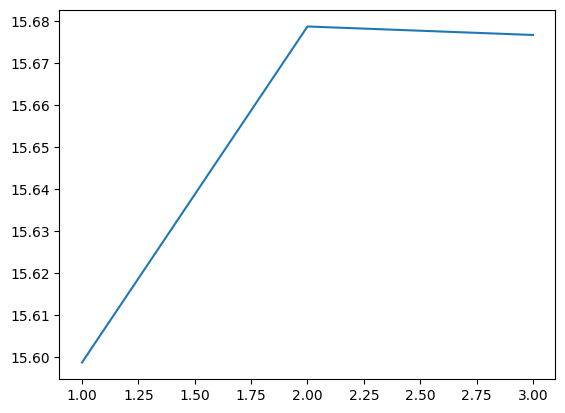

In [14]:
epochs = 3

## training in the cpu with the loss for the tokens excrutiatingly slow
## It becomes faster when we train with only the loss for the emotions
losses = train(model,epochs,device)

## Somewhat of a problem: Since we have padding for the emotions also,
## it quite affects the predictions...
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [17]:
def compute_test_loss(model,loss_fn,data_loader,device):
  model.eval()
  losses = []
  accs = []
  preds = [] ## predictions will be here
  prec = 0
  trues = [] ## true values will be here
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'texts' : batch['texts'].to(device),
             'emotions': batch['emotions'].to(device),
             'target_texts': batch['target_texts'].view(-1).to(device),
             'target_emotions': batch['target_emotions'].view(-1).to(device)}
    _ ,pe   = model.forward(batch['texts'],batch['emotions'])

    ## reshape so we can compute loss
    pe = pe.view(-1,8)

    ## For this computation, the token loss doesn't matter much...
    loss = loss_fn(pe,batch['target_emotions'])

    ## compute corrects:
    index_pred = torch.argmax(pe,1)
    correct = (batch['target_emotions'].flatten() == index_pred.flatten()).float().sum()
    acc = correct/len(index_pred.flatten())
    accs.append(acc.item())

    ## for plotting the loss:
    losses.append(loss.item())

    ## Saving true values and predictions:
    trues.extend(batch['target_emotions'].flatten().tolist())
    preds.extend(index_pred.tolist())

  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds

In [18]:
trues, preds = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader,device)

  0%|          | 0/200 [00:00<?, ?it/s]

average loss:  1.9879371798038483
average acc:  0.36204001545906067


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
names = [f'{i}' for i in range(0,8)]
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
print(confusion_matrix(trues,preds))

## to visually see how it compares:
print(trues[:300])
print(preds[:300])

              precision    recall  f1-score   support

           0       0.13      1.00      0.23      2553
           1       1.00      0.35      0.52     42974
           2       0.07      0.17      0.10       554
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        67
           5       0.75      0.08      0.14      2433
           6       0.11      0.06      0.08       758
           7       0.00      0.00      0.00       651

    accuracy                           0.36     50000
   macro avg       0.26      0.21      0.13     50000
weighted avg       0.90      0.36      0.47     50000

[[ 2553     0     0     0     0     0     0     0]
 [13984 15216   481   875     0    39   378 12001]
 [  458     0    96     0     0     0     0     0]
 [   10     0     0     0     0     0     0     0]
 [   60     0     7     0     0     0     0     0]
 [ 1622     1   524    32     6   190     3    55]
 [  584     0   124     3     0     0    47

In [ ]:
## finish later:

def eval_sentence(model, sentence, encoded_sentence, emotions, device):
  model.eval()
  for i in range(len(sentence) - 1):
    pe, _ = model.forward(encoded_sentence[i].to(device),emotions[i].to(device))
    t = torch.max(pe,1)
    print(f"word:{sentence[i+1]}; predicted_emotion: {t} ; target_emotion: {emotions[i+1]}")

# eval_sentence(model,sentence,encod,emot,device)